In [15]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

import matplotlib.pyplot as plt

import copy  # для сохранения лучшего состояния модели
import random
import os


Лочим seed

In [16]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


Загружаем датасет

In [17]:

df = pd.read_csv('cybersequrity.csv')
df

,svcscan.fs_drivers,callbacks.ngeneric,psxview.not_in_eprocess_pool_false_avg,psxview.not_in_eprocess_pool,callbacks.nanonymous,psxview.not_in_session,psxview.not_in_pslist,psxview.not_in_pspcid_list,psxview.not_in_ethread_pool,psxview.not_in_csrss_handles,psxview.not_in_pslist_false_avg,psxview.not_in_pspcid_list_false_avg,psxview.not_in_deskthrd,psxview.not_in_ethread_pool_false_avg,psxview.not_in_session_false_avg,Class
0,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.044444,1
1,26,8,0.0,0,0,5,3,3,3,7,0.073171,0.073171,9,0.073171,0.121951,1
2,26,8,0.0,0,0,9,7,7,7,11,0.152174,0.152174,13,0.152174,0.195652,1
3,26,8,0.0,0,0,3,1,1,2,6,0.022222,0.022222,9,0.044444,0.066667,1
4,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.048780,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,26,8,0.0,0,0,4,2,2,2,6,0.048780,0.048780,8,0.048780,0.097561,1
9996,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,5,0.000000,0.062500,1
9997,26,8,0.0,0,1,2,0,0,0,4,0.000000,0.000000,5,0.000000,0.062500,1
9998,26,8,0.0,0,0,8,6,6,7,11,0.127629,0.127629,13,0.148511,0.169392,0


Предобработка данных

In [18]:
# Проверка на пропуски
df.isnull().sum()

,0
svcscan.fs_drivers,0
callbacks.ngeneric,0
psxview.not_in_eprocess_pool_false_avg,0
psxview.not_in_eprocess_pool,0
callbacks.nanonymous,0
psxview.not_in_session,0
psxview.not_in_pslist,0
psxview.not_in_pspcid_list,0
psxview.not_in_ethread_pool,0
psxview.not_in_csrss_handles,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   svcscan.fs_drivers                      10000 non-null  int64  
 1   callbacks.ngeneric                      10000 non-null  int64  
 2   psxview.not_in_eprocess_pool_false_avg  10000 non-null  float64
 3   psxview.not_in_eprocess_pool            10000 non-null  int64  
 4   callbacks.nanonymous                    10000 non-null  int64  
 5   psxview.not_in_session                  10000 non-null  int64  
 6   psxview.not_in_pslist                   10000 non-null  int64  
 7   psxview.not_in_pspcid_list              10000 non-null  int64  
 8   psxview.not_in_ethread_pool             10000 non-null  int64  
 9   psxview.not_in_csrss_handles            10000 non-null  int64  
 10  psxview.not_in_pslist_false_avg         10000 non-null  flo

В качестве целевой переменной используйте столбец Class - бинарный столбец (0 - нейтральное ПО, 1 - вредоносное ПО)

In [20]:
# Разделение признаков и целевой переменной

X = df.drop("Class", axis=1).values  # Матрица признаков
y = df["Class"].values              # Вектор целевой переменной

Разделим датасет на обучающую, валидационную и тестовую выборки со стратификацией в пропорции 60/20/20.

In [21]:
# 1) Train + Temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,        # 40% от всего набора
    stratify=y,           # стратифицируем по целевой метке
    random_state=42
)

# 2) Val + Test (из X_temp, y_temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,        # 50% от X_temp -> в итоге 20% от всего набора
    stratify=y_temp,
    random_state=42
)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:  ", X_val.shape,   y_val.shape)
print("Test shape: ", X_test.shape,  y_test.shape)


Train shape: (6000, 15) (6000,)
Val shape:   (2000, 15) (2000,)
Test shape:  (2000, 15) (2000,)


Для ускорения сходимости и стабилизации обучения стандартизируем входные признаки с помощью StandardScaler

In [22]:
scaler = StandardScaler()

# Обучаем скейлер на тренировочных данных и одновременно трансформируем их
X_train_scaled = scaler.fit_transform(X_train)

# Для валид. и тестовых — только transform, без fit,
# чтобы не подглядывать в будущее и не «портить» честную оценку
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Создаем объекты для работы с данными в PyTorch - Dataset и DataLoader для обучающей, валидационной и тестовой выборок.

In [23]:
class MalwareDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        # Возвращаем кортеж (признаки, метка)
        return self.X[index], self.y[index]

In [24]:
train_dataset = MalwareDataset(X_train_scaled, y_train)
val_dataset   = MalwareDataset(X_val_scaled,   y_val)
test_dataset  = MalwareDataset(X_test_scaled,  y_test)

Выбираем batch_size

64 — не слишком маленький, чтобы обучение шло слишком долго (т.к. слишком маленький батч увеличивает число итераций и даёт очень «шумные» градиенты).
И не слишком большой, чтобы «проглотить» всю память GPU или слишком сгладить градиенты.


In [25]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print(f"Train loader steps per epoch: {len(train_loader)}")
print(f"Val loader steps per epoch:   {len(val_loader)}")
print(f"Test loader steps per epoch:  {len(test_loader)}")

Train loader steps per epoch: 94
Val loader steps per epoch:   32
Test loader steps per epoch:  32


In [26]:
# Проверяем, доступен ли GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [27]:
class BaselineMLP(nn.Module):
    def __init__(self, input_dim):
        super(BaselineMLP, self).__init__()

        # Слой 1: вход -> 64
        self.fc1 = nn.Linear(input_dim, 64)

        # Слой 2: 64 -> 32
        self.fc2 = nn.Linear(64, 32)

        # Выходной слой: 32 -> 1
        self.fc3 = nn.Linear(32, 1)

    # Реализуем логику прохождения данных по сети в методе forward
    def forward(self, x):
        # Прямой проход (forward pass)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Выход с сигмоидой
        x = torch.sigmoid(self.fc3(x))

        # Выходная размерность: [batch_size, 1]
        return x


In [28]:
input_dim = X_train_scaled.shape[1]
model = BaselineMLP(input_dim=input_dim)

In [29]:
# Переводим модель на GPU (если доступен)
model.to(device)

print(model)


BaselineMLP(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [48]:
# используем Adam
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

In [32]:
num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Обучаем
    model.train()  # режим обучения (Dropout/BatchNorm и т.д.)
    running_train_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Переносим данные на GPU, если он доступен
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Предсказание
        y_pred = model(X_batch)

        # Сброс градиентов
        optimizer.zero_grad()

        # Подсчёт лосса
        loss = criterion(y_pred.squeeze(), y_batch)

        # Backward
        loss.backward()

        # Обновление параметров
        optimizer.step()

        running_train_loss += loss.item()

    # Подсчёт среднего лосса за эпоху
    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Валидируем
    model.eval()  # режим валидации (выключается Dropout/BatchNorm)
    running_val_loss = 0.0

    # Отключаем автоград для валидации
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred.squeeze(), y_val_batch)
            running_val_loss += val_loss.item()

    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}")


Epoch [1/10] Train Loss: 0.6801 | Val Loss: 0.6716
Epoch [2/10] Train Loss: 0.6643 | Val Loss: 0.6564
Epoch [3/10] Train Loss: 0.6471 | Val Loss: 0.6439
Epoch [4/10] Train Loss: 0.6313 | Val Loss: 0.6285
Epoch [5/10] Train Loss: 0.6152 | Val Loss: 0.6089
Epoch [6/10] Train Loss: 0.5966 | Val Loss: 0.5896
Epoch [7/10] Train Loss: 0.5766 | Val Loss: 0.5693
Epoch [8/10] Train Loss: 0.5585 | Val Loss: 0.5520
Epoch [9/10] Train Loss: 0.5400 | Val Loss: 0.5336
Epoch [10/10] Train Loss: 0.5258 | Val Loss: 0.5155


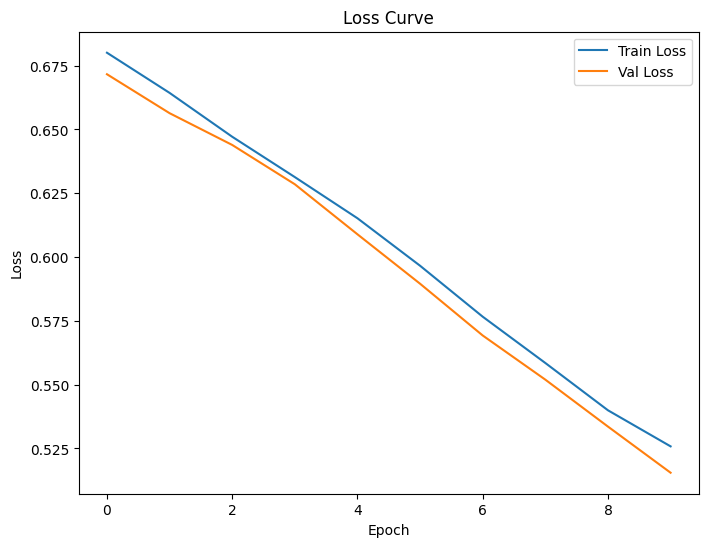

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()


На первый взгляд график выглядит вполне нормальным: лосс на тренировке и валидации убывает и не расходится, что говорит о том, что модель понемногу обучается.

In [35]:
# Гиперпараметры
num_epochs = 20            # Подбераем эмпирически
learning_rate = 1e-3       # 1e-3, 5e-4, 1e-4 и т.д.
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Для сохранения лучшей модели
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Обучаем
    model.train()
    running_train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        y_pred = model(X_batch)

        # Подсчёт лосса
        loss = criterion(y_pred.squeeze(), y_batch)

        # Обратное распространение
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Валидируем
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred.squeeze(), y_val_batch)
            running_val_loss += val_loss.item()

    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    # Проверяем, не улучшилась ли валидация
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}")


Epoch [1/20] Train Loss: 0.4537 | Val Loss: 0.4505
Epoch [2/20] Train Loss: 0.4496 | Val Loss: 0.4475
Epoch [3/20] Train Loss: 0.4461 | Val Loss: 0.4435
Epoch [4/20] Train Loss: 0.4447 | Val Loss: 0.4426
Epoch [5/20] Train Loss: 0.4481 | Val Loss: 0.4429
Epoch [6/20] Train Loss: 0.4422 | Val Loss: 0.4509
Epoch [7/20] Train Loss: 0.4447 | Val Loss: 0.4428
Epoch [8/20] Train Loss: 0.4375 | Val Loss: 0.4419
Epoch [9/20] Train Loss: 0.4419 | Val Loss: 0.4385
Epoch [10/20] Train Loss: 0.4340 | Val Loss: 0.4341
Epoch [11/20] Train Loss: 0.4352 | Val Loss: 0.4364
Epoch [12/20] Train Loss: 0.4360 | Val Loss: 0.4536
Epoch [13/20] Train Loss: 0.4350 | Val Loss: 0.4316
Epoch [14/20] Train Loss: 0.4331 | Val Loss: 0.4314
Epoch [15/20] Train Loss: 0.4296 | Val Loss: 0.4275
Epoch [16/20] Train Loss: 0.4279 | Val Loss: 0.4277
Epoch [17/20] Train Loss: 0.4282 | Val Loss: 0.4254
Epoch [18/20] Train Loss: 0.4302 | Val Loss: 0.4356
Epoch [19/20] Train Loss: 0.4258 | Val Loss: 0.4381
Epoch [20/20] Train L

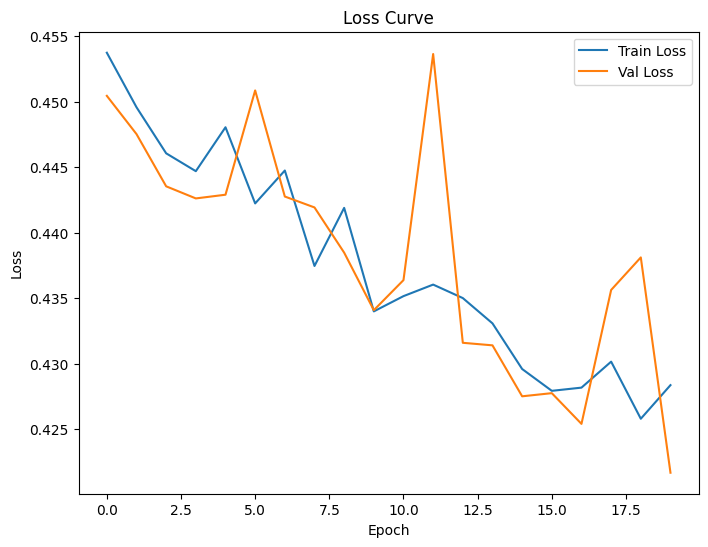

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()


Лоссы стали ниже

In [45]:
# Гиперпараметры
num_epochs = 100            # Подбераем эмпирически
learning_rate = 5e-4       # 1e-3, 5e-4, 1e-4 и т.д.
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Для сохранения лучшей модели
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Обучаем
    model.train()
    running_train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        y_pred = model(X_batch)

        # Подсчёт лосса
        loss = criterion(y_pred.squeeze(), y_batch)

        # Обратное распространение
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Валидируем
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred.squeeze(), y_val_batch)
            running_val_loss += val_loss.item()

    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    # Проверяем, не улучшилась ли валидация
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}")


Epoch [1/100] Train Loss: 0.3619 | Val Loss: 0.3553
Epoch [2/100] Train Loss: 0.3566 | Val Loss: 0.3610
Epoch [3/100] Train Loss: 0.3553 | Val Loss: 0.3651
Epoch [4/100] Train Loss: 0.3589 | Val Loss: 0.3611
Epoch [5/100] Train Loss: 0.3569 | Val Loss: 0.3550
Epoch [6/100] Train Loss: 0.3564 | Val Loss: 0.3596
Epoch [7/100] Train Loss: 0.3586 | Val Loss: 0.3605
Epoch [8/100] Train Loss: 0.3558 | Val Loss: 0.3574
Epoch [9/100] Train Loss: 0.3612 | Val Loss: 0.3658
Epoch [10/100] Train Loss: 0.3604 | Val Loss: 0.3598
Epoch [11/100] Train Loss: 0.3588 | Val Loss: 0.3557
Epoch [12/100] Train Loss: 0.3553 | Val Loss: 0.3611
Epoch [13/100] Train Loss: 0.3621 | Val Loss: 0.3635
Epoch [14/100] Train Loss: 0.3646 | Val Loss: 0.3548
Epoch [15/100] Train Loss: 0.3556 | Val Loss: 0.3541
Epoch [16/100] Train Loss: 0.3572 | Val Loss: 0.3540
Epoch [17/100] Train Loss: 0.3555 | Val Loss: 0.3536
Epoch [18/100] Train Loss: 0.3547 | Val Loss: 0.3761
Epoch [19/100] Train Loss: 0.3583 | Val Loss: 0.3522
Ep

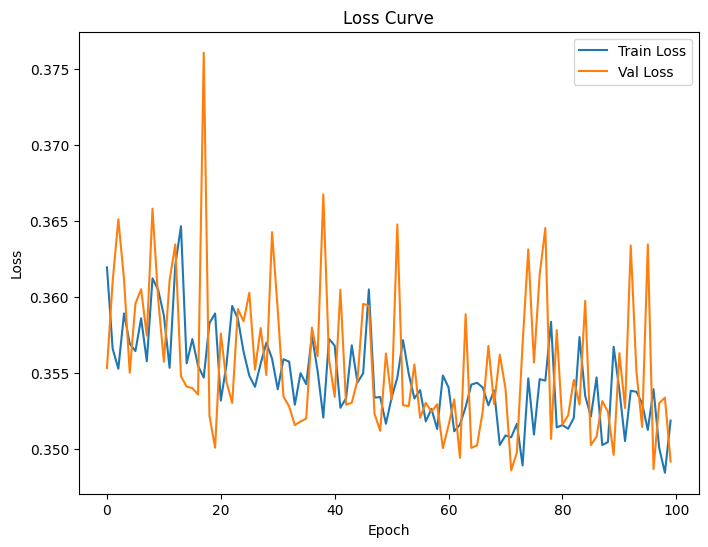

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()


Модель в целом учится, хотя и «шумно». Судя по логу, Train Loss и Val Loss ведут себя довольно хаотично: бывают скачки вверх и вниз, но при этом оба постепенно снижаются, а под конец (на 100-й эпохе) Val Loss оказывается около 0.3492, что ниже, чем значения в начале обучения (в районе 0.36–0.37). Это говорит о том, что в целом сходимость есть, хотя и колеблется

Сохраняем лучшую модель

In [47]:
model.load_state_dict(best_model_wts)
print("Loaded the best model (with lowest val_loss).")

Loaded the best model (with lowest val_loss).


Измеряем качество лучшей модели на тестовой выборке, строим отчет о классификации - classification_report

In [49]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Предсказываем вероятности класса 1
        y_prob = model(X_batch).squeeze()  # shape = [batch_size]

        # Переводим в CPU и numpy
        y_prob_cpu = y_prob.cpu().numpy()
        y_batch_cpu = y_batch.cpu().numpy()

        # Предсказываем класс (0 или 1), используя порог 0.5
        y_pred_cpu = (y_prob_cpu >= 0.5).astype(int)

        # Сохраняем предсказания и истинные значения
        all_preds.extend(y_pred_cpu)
        all_labels.extend(y_batch_cpu)

# Теперь можем построить отчет
report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report on TEST:")
print(report)


Classification Report on TEST:
              precision    recall  f1-score   support

         0.0     0.8043    0.8716    0.8366       981
         1.0     0.8655    0.7959    0.8292      1019

    accuracy                         0.8330      2000
   macro avg     0.8349    0.8337    0.8329      2000
weighted avg     0.8355    0.8330    0.8328      2000



In [104]:
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, p_dropout=0.0):
        """
        Улучшенная MLP-модель.

        Параметры:
        -----------
        input_dim : int
            Размерность входных данных (число признаков).
        p_dropout : float
            Вероятность 'выбрасывания' нейронов во время обучения (Dropout).
            По умолчанию 0.0 (Dropout отключён).
        """
        super(ImprovedMLP, self).__init__()

        # 1-й блок: Linear -> BatchNorm -> ReLU -> Dropout
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(p=p_dropout)

        # 2-й блок: Linear -> BatchNorm -> ReLU -> Dropout
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(p=p_dropout)

        # Выходной слой (Linear -> Sigmoid)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        """
        Логика прямого прохода.
        На выходе: значения из [0,1] (т.к. Sigmoid)
        Подходит для nn.BCELoss().
        """
        # 1-й блок
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # 2-й блок
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Выход (с Sigmoid, т.к. используется BCELoss)
        x = torch.sigmoid(self.fc3(x))
        return x


In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedMLPAltOrder(nn.Module):
    def __init__(self, input_dim, p_dropout=0.0):
        """
        Улучшенная MLP-модель с порядком:
        Linear -> ReLU -> BatchNorm -> Dropout

        Параметры:
        -----------
        input_dim : int
            Размерность входных данных (число признаков).
        p_dropout : float
            Вероятность 'выбрасывания' нейронов во время обучения (Dropout).
            По умолчанию 0.0 (Dropout отключён).
        """
        super(ImprovedMLPAltOrder, self).__init__()

        # 1-й блок: Linear -> ReLU -> BatchNorm -> Dropout
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(p=p_dropout)

        # 2-й блок: Linear -> ReLU -> BatchNorm -> Dropout
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(p=p_dropout)

        # Выходной слой (Linear -> Sigmoid)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        """
        Логика прямого прохода.
        На выходе: значения из [0,1] (т.к. Sigmoid)
        Подходит для nn.BCELoss().
        """
        # 1-й блок: Linear -> ReLU -> BatchNorm -> Dropout
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.dropout1(x)

        # 2-й блок: Linear -> ReLU -> BatchNorm -> Dropout
        x = self.fc2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.dropout2(x)

        # Выход (с Sigmoid, т.к. используем BCELoss)
        x = torch.sigmoid(self.fc3(x))
        return x


p=0.3 кажется, что даёт слишком «шумное» обучение, поэтому пробуем 0.2, 0,1. При 0.1 модель показывает лучшие результаты и не переобучается

Epoch [1/100] Train Loss: 0.6234 | Val Loss: 0.6098
Epoch [2/100] Train Loss: 0.5511 | Val Loss: 0.5730
Epoch [3/100] Train Loss: 0.5148 | Val Loss: 0.5587
Epoch [4/100] Train Loss: 0.4881 | Val Loss: 0.5374
Epoch [5/100] Train Loss: 0.4730 | Val Loss: 0.5139
Epoch [6/100] Train Loss: 0.4653 | Val Loss: 0.5323
Epoch [7/100] Train Loss: 0.4521 | Val Loss: 0.5066
Epoch [8/100] Train Loss: 0.4422 | Val Loss: 0.5026
Epoch [9/100] Train Loss: 0.4495 | Val Loss: 0.5221
Epoch [10/100] Train Loss: 0.4358 | Val Loss: 0.4418
Epoch [11/100] Train Loss: 0.4341 | Val Loss: 0.5069
Epoch [12/100] Train Loss: 0.4220 | Val Loss: 0.4430
Epoch [13/100] Train Loss: 0.4211 | Val Loss: 0.4981
Epoch [14/100] Train Loss: 0.4116 | Val Loss: 0.4419
Epoch [15/100] Train Loss: 0.4147 | Val Loss: 0.4311
Epoch [16/100] Train Loss: 0.4108 | Val Loss: 0.4939
Epoch [17/100] Train Loss: 0.4005 | Val Loss: 0.4620
Epoch [18/100] Train Loss: 0.4081 | Val Loss: 0.4381
Epoch [19/100] Train Loss: 0.4073 | Val Loss: 0.4708
Ep

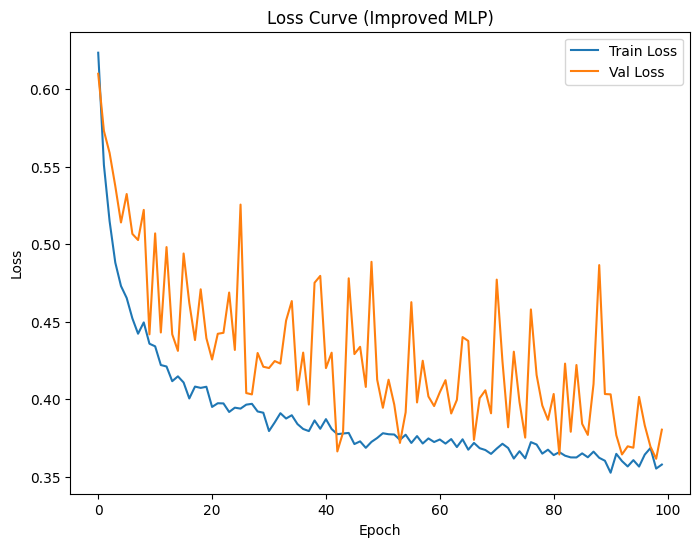

In [107]:
# Создаём модель
input_dim = X_train_scaled.shape[1]
p_dropout = 0.0  # подберем эмпирически
model = ImprovedMLPAltOrder(input_dim=input_dim, p_dropout=p_dropout).to(device)

# Оптимизатор и функция потерь
learning_rate = 5e-4
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Гиперпараметры цикла обучения
num_epochs = 100
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # 1. TRAIN
    model.train()
    running_train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)  # squeeze -> [batch_size]
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # 2. VALIDATION
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred.squeeze(), y_val_batch)
            running_val_loss += val_loss.item()

    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    # Сохраняем лучшую модель, если валидационный лосс улучшился
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}")

# Загрузка лучших весов
model.load_state_dict(best_model_wts)
print("Loaded best model weights (with minimum val_loss).")

# Визуализация лоссов
plt.figure(figsize=(8, 6))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve (Improved MLP)')
plt.legend()
plt.show()


In [108]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_prob = model(X_batch).squeeze()

        y_prob_cpu = y_prob.cpu().numpy()
        y_batch_cpu = y_batch.cpu().numpy()

        y_pred_cpu = (y_prob_cpu >= 0.5).astype(int)

        all_preds.extend(y_pred_cpu)
        all_labels.extend(y_batch_cpu)

report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report (Improved MLP) on TEST:")
print(report)


Classification Report (Improved MLP) on TEST:
              precision    recall  f1-score   support

         0.0     0.8119    0.8624    0.8364       981
         1.0     0.8591    0.8077    0.8326      1019

    accuracy                         0.8345      2000
   macro avg     0.8355    0.8350    0.8345      2000
weighted avg     0.8359    0.8345    0.8344      2000



**BatchNorm:**

При правильном расположении (например, Linear -> ReLU -> BatchNorm) помог стабилизировать обучение и улучшил итоговые метрики.
В задачах, где признаки уже отнормированы и сеть не переобучается, эффект может быть меньше, но здесь дало прирост точности.

**Dropout:**

Сильная регуляризация (p=0.3–0.5) приводила к ухудшению результата, поскольку переобучение не было существенным.
При p_dropout=0.0 (отключённом Dropout) сеть показала наивысшую точность, значит в данной задаче дополнительная регуляризация не нужна.

Порядок «Linear → ReLU → BatchNorm» оказался эффективнее, чем «Linear → BatchNorm → ReLU».
При этом отключённый Dropout (или минимальный) дал лучший итоговый результат.

Если нет сильного переобучения, большой Dropout лишь мешает «дожать» метрику.
BatchNorm целесообразен, когда правильный порядок слоёв заметно снижает валид. лосс.